# Amazon Alexa Sentiment Analysis

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
#import en_core_web_sm


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#reading file
df=pd.read_csv("amazon_alexa.tsv",sep="\t")
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
df.shape


(3150, 5)

In [5]:
df.describe()


,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [6]:
df.isna().mean(axis=0)

rating              0.0
date                0.0
variation           0.0
verified_reviews    0.0
feedback            0.0
dtype: float64

In [7]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

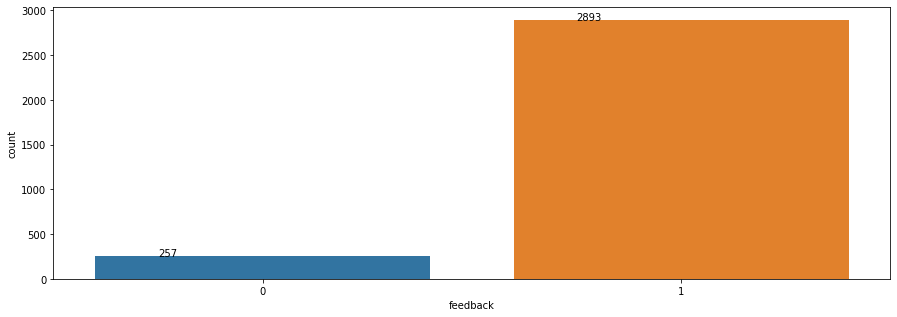

In [8]:
plt.figure(figsize=(15,5))
ax=sns.countplot(data=df,x='feedback');
#for p, label in zip(ax.patches, df["feedback"].value_counts().index):
 #   ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [9]:
df['feedback'].mean()

0.9184126984126985

91% of the data has positive reviews

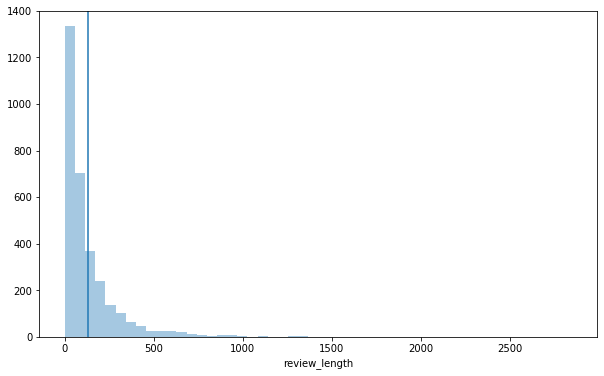

In [10]:
#seeing the distribution of word length
df['review_length']=df['verified_reviews'].apply(len)

fig = plt.figure(1, figsize=(10,6))
sns.distplot(df['review_length'],kde=False);
plt.axvline(x=df['review_length'].mean(), ymin=0,ymax=1);

In [11]:
df['review_length'].mean()

132.0495238095238

Avergae review length is around 132 words.

In [12]:
df['date']=pd.to_datetime(df['date'], format="%d-%b-%y")
df.dtypes

rating                       int64
date                datetime64[ns]
variation                   object
verified_reviews            object
feedback                     int64
review_length                int64
dtype: object

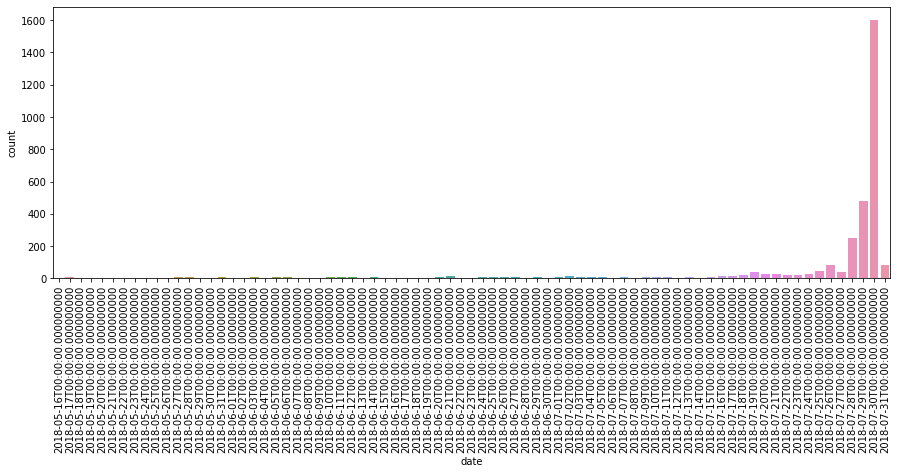

In [13]:
plt.figure(figsize=(15,5))
ax=sns.countplot(df['date'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


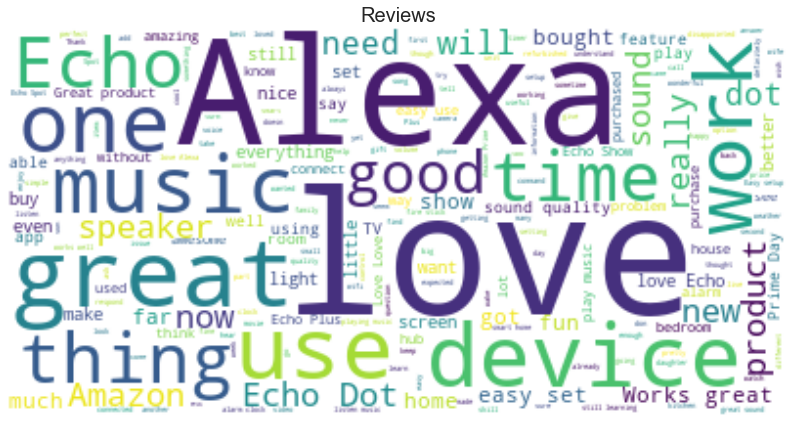

In [14]:
np.random.seed(10)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

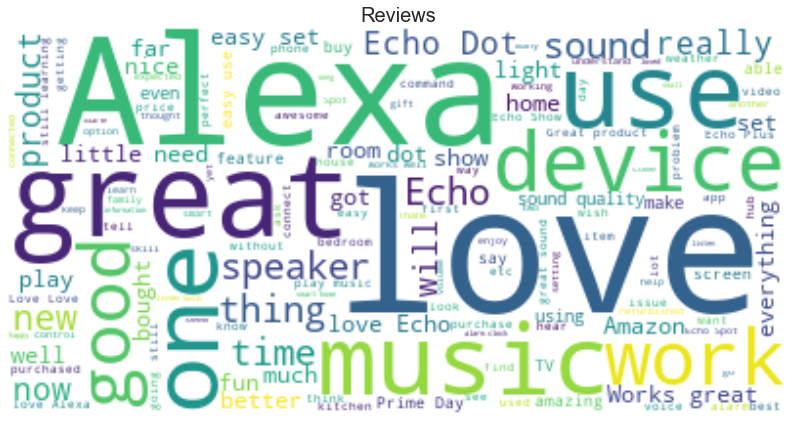

In [15]:
df_positive=df[df['feedback']==1]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_positive['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Mostly contains words such as alexa, love,music,one,speaker,good,device,great

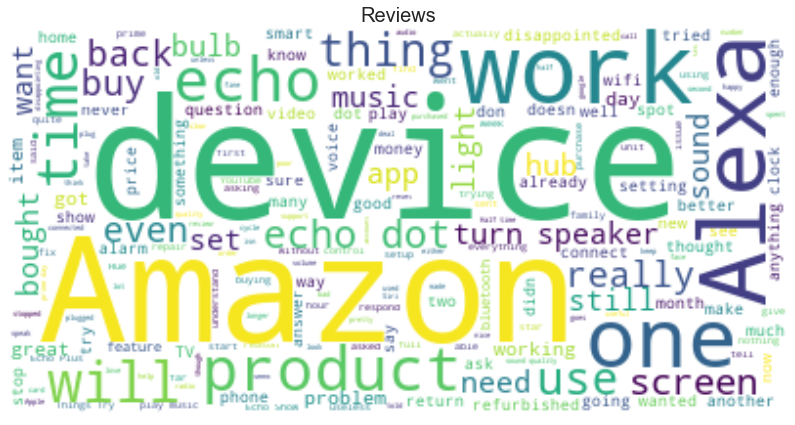

In [16]:
df_negative=df[df['feedback']==0]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_negative['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Contains words like never,disappointed,tried,problem,still.

### Tokenizing data with Spacy

Let's create a custom function using spacy which will automatically strip words that we dont need. Few of these words include stopwords, punctuations, special characters.

### Using BOW
#### Tokenization

In [17]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

In [18]:
def data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_!='-PRON-':
            temp=token.lemma_.lower().strip()
        else:
            temp=token.lower_
        tokens.append(temp)
            
    cleaned_tokens=[]
    for token in tokens:
        if token not in stop_words and token not in punctuations:
            cleaned_tokens.append(token)
    
    return cleaned_tokens
            

    

 ### Vectorization Feature Engineering (TF-IDF):

In [19]:
from sklearn.svm import LinearSVC

In [20]:
tfidf_vector = TfidfVectorizer(tokenizer = data_cleaning,ngram_range=(1,2))

In [21]:
classifier=LinearSVC()
X=df['verified_reviews']
y=df['feedback']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [23]:
pipe = Pipeline([('tfidf', tfidf_vector),
                 ('clf', classifier)])

In [24]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function data_cleaning at 0x0000029BD7AED1E0>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=

In [25]:
predicted = pipe.predict(X_test)

In [26]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.88      0.30      0.45        76
           1       0.94      1.00      0.97       869

    accuracy                           0.94       945
   macro avg       0.91      0.65      0.71       945
weighted avg       0.94      0.94      0.93       945



In [27]:
confusion_matrix(y_test,predicted)

array([[ 23,  53],
       [  3, 866]], dtype=int64)

In [28]:
pipe.predict(['return'])

array([0], dtype=int64)

In [29]:
from sklearn import metrics
#Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9407407407407408
Logistic Regression Precision: 0.9423286180631121
Logistic Regression Recall: 0.996547756041427


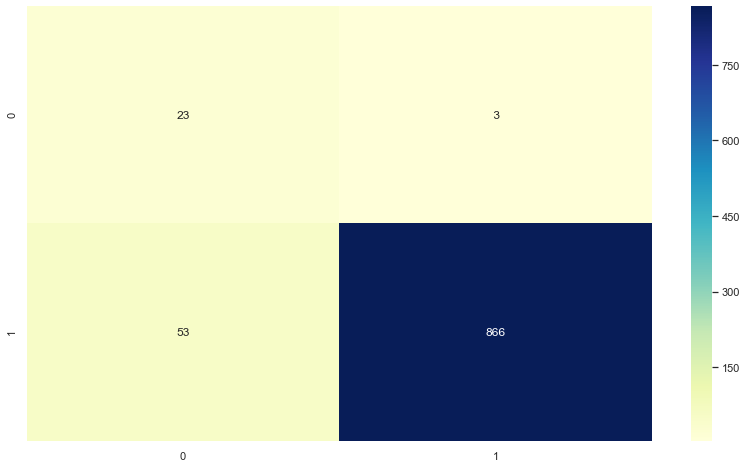

In [30]:
sns.heatmap(metrics.confusion_matrix(predicted,y_test),annot=True,fmt='2.0f', cmap="YlGnBu")

## Classification

### 1. Random Forest classification

In [31]:
from nltk.tokenize import word_tokenize
word_tokenize(df.verified_reviews[0])

['Love', 'my', 'Echo', '!']

In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

sw = set(stopwords.words('english'))

df['token_reviews'] = df.verified_reviews.apply(lambda x: word_tokenize(x))
df['clean_reviews'] = df.token_reviews.apply(lambda x : [word for word in x if word not in sw] )
df['clean_reviews'] = df.clean_reviews.apply(lambda x : " ".join(x))


In [33]:
df.head()

,rating,date,variation,verified_reviews,feedback,review_length,token_reviews,clean_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,13,"[Love, my, Echo, !]",Love Echo !
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,9,"[Loved, it, !]",Loved !
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195,"[Sometimes, while, playing, a, game, ,, you, c...","Sometimes playing game , answer question corre..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172,"[I, have, had, a, lot, of, fun, with, this, th...",I lot fun thing . My 4 yr old learns dinosaurs...
4,5,2018-07-31,Charcoal Fabric,Music,1,5,[Music],Music


In [34]:
y = df['feedback']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_reviews"], y, test_size=0.3,random_state=10)

In [36]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

y_train = np.asarray(y_train.values)

ch2 = SelectKBest(chi2, k = 300)

X_new = ch2.fit_transform(count_train, y_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

X_test_new = ch2.transform(X=count_test)

In [37]:
count_vectorizer = CountVectorizer(stop_words="english")

def TextPreprocessor(train,train_y,test):
        
    CountVectorizer(stop_words="english")
    count = count_vectorizer.fit_transform(train)
    count_test = count_vectorizer.transform(X_test)
    
    tfidf_vectorizer = TfidfTransformer()
    tfidf = tfidf_vectorizer.fit_transform(count)
    tfidf_test = tfidf_vectorizer.transform(count_test)
    
    ch2 = SelectKBest(chi2, k = 300)
    
    X_new = ch2.fit_transform(count_train, y_train)
    
    train_new = ch2.fit_transform(tfidf, y_train)
    test_new = ch2.transform(tfidf_test)
    
    return train_new, test_new

In [38]:
train_set, test_set = TextPreprocessor(X_train, y_train, X_test)

In [39]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

rf_clf = RandomForestClassifier(random_state=10)
# Fit the classifier to the training data
rf_clf.fit(train_set, y_train)

# Create the predicted tags: pred
pred_rf = rf_clf.predict(test_set)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred_rf)
print('Accuracy is:',score)

f1 = metrics.f1_score(y_test, pred_rf)
print('F score is:',f1)

Accuracy is: 0.9343915343915344
F score is: 0.9652466367713005


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


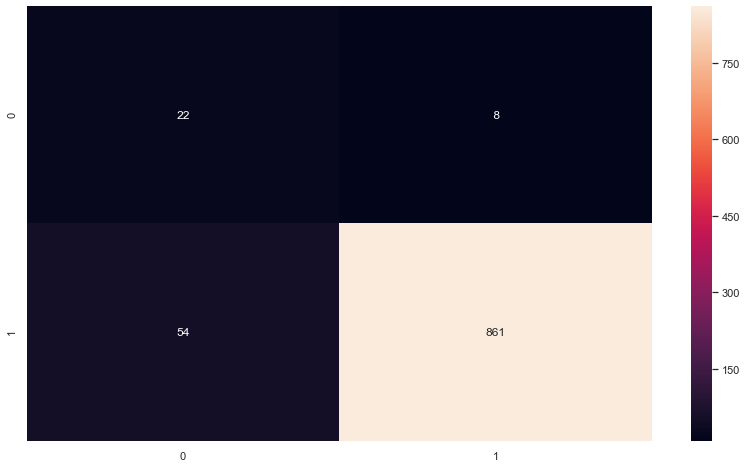

In [40]:
sns.heatmap(metrics.confusion_matrix(pred_rf,y_test),annot=True,fmt='2.0f')

In [41]:
from sklearn.model_selection import GridSearchCV
randfor_clf = RandomForestClassifier()
metrics_score = metrics.make_scorer(metrics.fbeta_score, beta=0.5)
parameters = {'n_estimators': [150, 180, 250], 'max_features': [120,150], 'max_depth': [120,135,150],'min_samples_split':[3,5],'min_samples_leaf':[1,3,5]}

grid_obj = GridSearchCV(randfor_clf, parameters, scoring=metrics_score)

grid_fit = grid_obj.fit(X_new, y_train)


C:\Users\leksh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [42]:
best_randforclf = grid_fit.best_estimator_

best_predictions = best_randforclf.predict(X_test_new)

score = metrics.accuracy_score(y_test, best_predictions)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, best_predictions)
print('F score is:',f1)

Accuracy is: 0.9301587301587302
F score is: 0.9628796400449944


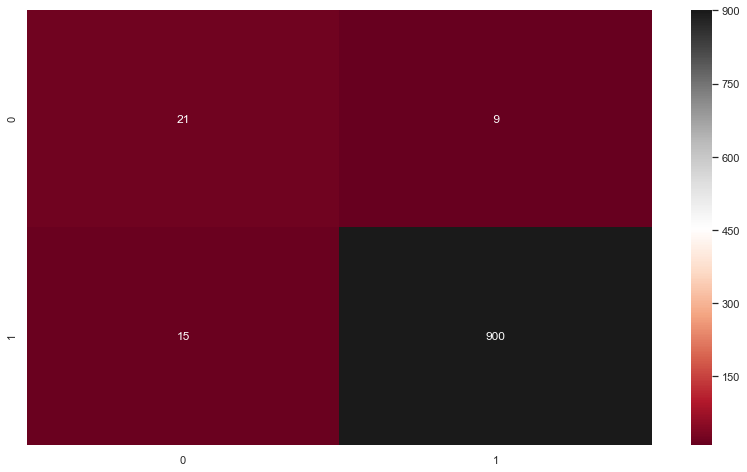

In [43]:
sns.heatmap(metrics.confusion_matrix(pred_rf,best_predictions),annot=True,fmt='2.0f', cmap="RdGy")

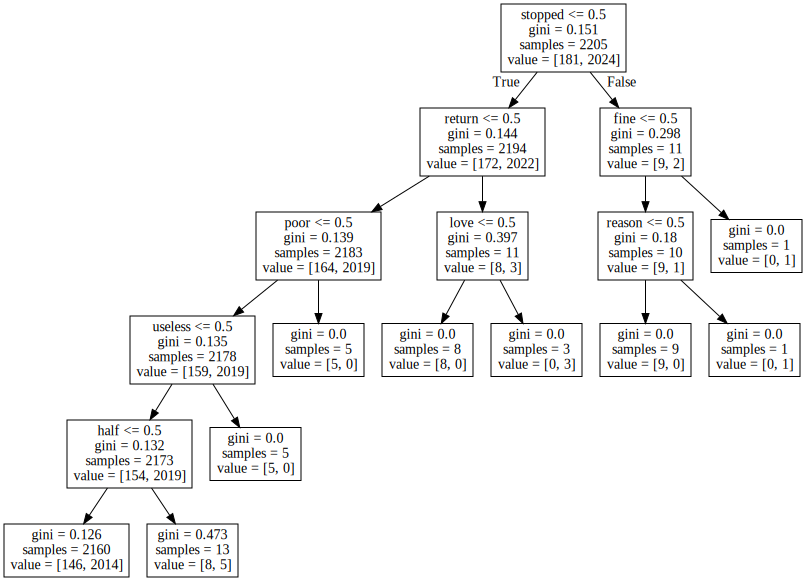

In [50]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, feature_names=features)
graphviz.Source(tree_graph)